# Sample control spending and saving data

In this notebook I've run some basic descriptive analyses on a sample of 100 kids from ATB. These are not kids who got or are getting Dojo. This is simply so we can explore spending and saving behaviour in broad strokes more naturally, as a comparison point for understanding the potential behavior change after a child starts interacting with the Dojo platform.

## Setup

As always, first things first I need to do a little bit of data munging to get everything into useable shape.

In [4]:
# Getting the packages I need for now
import pandas as pd
import numpy as np

# Read the data file in
data = pd.read_csv('dojo_100bp_sample_trxn_listing_18039.csv')

# Getting a list of all the column names
col_names = data.columns.tolist()


In [5]:
# Just a couple fixes to turn the transaction amounts into numbers.
# Removing commas and converting to numeric
data['Trxn Amount'] = data['Trxn Amount'].str.replace(",", "")
data['Trxn Amount'] = pd.to_numeric(data['Trxn Amount'])

# Just get a quick look at what the columns in the data set are.
print(col_names) # Just get a quick look at what the columns in the data set are


['Primary BP', 'Joint BP', 'Birth Dt', 'Postal', 'Age Grp', 'Urban Rural', 'Acct Oid', 'Product', 'Start Date', 'Rpt Month', ' Opening Balance ', 'Closing Balance', 'Trxn Type', 'Trxn Description', 'Trxn create date', 'Debit Credit Flg', 'Trxn Amount', 'Trxn Group', 'Pymt Note Code', 'Payment Details', 'EFT code', 'EFT Details', 'Channel', 'Reference Bank']


In [7]:
print(data.info())
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6475 entries, 0 to 6474
Data columns (total 24 columns):
Primary BP           6475 non-null int64
Joint BP             6475 non-null int64
Birth Dt             6475 non-null object
Postal               6468 non-null object
Age Grp              6475 non-null object
Urban Rural          6475 non-null object
Acct Oid             6475 non-null int64
Product              6475 non-null object
Start Date           6475 non-null object
Rpt Month            6475 non-null object
 Opening Balance     6475 non-null object
Closing Balance      6384 non-null object
Trxn Type            6449 non-null float64
Trxn Description     6449 non-null object
Trxn create date     6475 non-null object
Debit Credit Flg     6449 non-null object
Trxn Amount          6449 non-null float64
Trxn Group           6449 non-null object
Pymt Note Code       6475 non-null object
Payment Details      4747 non-null object
EFT code             213 non-null float64
EFT Details 

In [8]:
# Just checking to make sure there are 100 unique kids
print(len(set(data['Primary BP'])))

100


Everything looks good so far. Lets just take a quick look and see how many transactions were made (by 100 kids, over a 6 month period).

In [9]:
print(data['Debit Credit Flg'].value_counts())

DB    5052
CR    1397
Name: Debit Credit Flg, dtype: int64


Seems like there are way more outgoing that incoming transactions, which makes total sense. You might buy things everyday, but get paid once a week or every two weeks. Lets dig into this a little deeper -  what is the total amount of money that was moven in these transactions?

In [10]:
amounts_moved_new = pd.pivot_table(data, values='Trxn Amount',
                               index=['Debit Credit Flg'], aggfunc=sum)
print(amounts_moved_new)

                  Trxn Amount
Debit Credit Flg             
CR                  329805.99
DB                  306922.09


Wow, so these kids are moving some money. Apparently, over 6 months these 100 kids earned approximately $330,000 and spent nearly the same.

This obviously has to be some sort of issue. When I dig into the raw data a little bit to take a look there are some odd things in there that I really have no way of explaining. For example, one kid recieved a ~$30,000 deposit, which was then withdrew, and then another similarly large sum deposited, etc. This particular kid accounted for most of this money movement.

Let's break this down a little bit more and take a look at the total money movement across the age categories, and get an aggregate savings rate based on the total amount of debits and credits. Note: this 

In [12]:
amounts_moved_age = pd.pivot_table(data, values='Trxn Amount', index='Age Grp', columns=['Debit Credit Flg'],
                                   aggfunc=sum)
print(amounts_moved_age)

Debit Credit Flg         CR         DB
Age Grp                               
1. 1 to 9 yrs      38835.17   32460.24
2. 10 to 12 yrs     1414.18    1227.10
3. 13 to 14 yrs    15046.96   12201.84
4. 15 yrs           8533.27    6857.60
5. 16 yrs          45034.17   49171.85
6. 17 yrs         220942.24  205003.46


Okay, so it seems like in most of the cases, the age groups on ON THE WHOLE spending less than they are earning, which is good! When you look at these numbers as is, the savings rate is about 10%, though it drops lower (even going negative) as the kids get older. Which is not at all surprising, as thats when kids are getting more autonomy, driving, etc.

Here is just a quick visualization of the savings rate from the aggregate data in the above table.

[Text(0,0,u'1 to 9'),
 Text(0,0,u'10 to 12'),
 Text(0,0,u'13 to 14'),
 Text(0,0,u'15'),
 Text(0,0,u'16'),
 Text(0,0,u'17')]

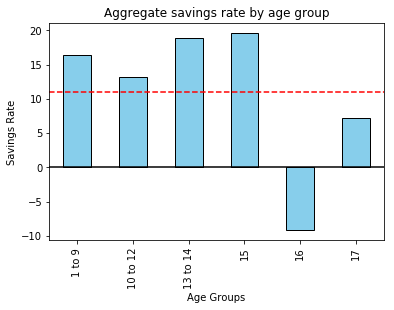

In [15]:
# Trying to plot this pivot table
import matplotlib.pyplot as plt
amounts_moved_age['savings'].plot.bar(color='skyblue', ec='black')
plt.ylabel('Savings Rate')
plt.title('Aggregate savings rate by age group')
plt.xlabel('Age Groups')
plt.axhline(amounts_moved_age['savings'].mean(), linestyle='dashed', color='red')
plt.axhline(0, color='black')
plt.gca().set_xticklabels(['1 to 9', '10 to 12', '13 to 14', '15', '16', '17'])

Here, the red line is the average savings rate, about 12%.

Moving on from these aggregates though, lets actually calculate how much money was earned and spent for each kid individually and look at what the savings rates really are. That is, the real averages taking every kid into account.

## Spending and Saving by Kid

First things first, the below chunk of code will group our data by kid and sum about the totals of their transactions, both credits and debits. So we can see, for example, the first kid (ID 613570) earned $0.36, and spent nothing. The second kid (ID 623262) earned $5590.99 and spent $5249.68.

In [16]:
# Summaries of spending and saving by kid
cols = ['Primary BP', 'Debit Credit Flg', 'Trxn Amount']
transact_data = data[cols]
data_grouped = transact_data.groupby(['Primary BP', 'Debit Credit Flg'], as_index=False).agg('sum')
print(data_grouped)


     Primary BP Debit Credit Flg  Trxn Amount
0        613570               CR         0.36
1        623262               CR      5590.99
2        623262               DB      5249.68
3        654016               CR     13080.29
4        654016               DB     13253.80
5        800222               CR     23309.62
6        800222               DB     25773.65
7        904341               CR      3725.76
8        904341               DB      3734.65
9        932022               CR     10861.84
10       932022               DB     11305.51
11       938237               CR      4288.24
12       938237               DB      3800.17
13       938266               CR       250.00
14       938266               DB       192.14
15      1299498               CR       560.61
16      1299498               DB      1000.00
17      1300140               CR         1.36
18      1300744               CR       205.07
19      1300744               DB       280.40
20      1305122               CR  

From here we want to actually get savings rates for each individual kid. I'm going to do that with dictionaries here.

In [17]:
# Amount of money saved and  savings rate by kid in a dictionary
data_grouped.loc[data_grouped['Debit Credit Flg'] == 'DB', ['Trxn Amount']] *= -1
test = data_grouped.groupby('Primary BP')['Trxn Amount'].sum().to_dict()

earnings = data_grouped.loc[data_grouped['Debit Credit Flg'] == 'CR']
spending = data_grouped.loc[data_grouped['Debit Credit Flg'] == 'DB']

earning_dict = earnings.groupby('Primary BP')['Trxn Amount'].sum().to_dict()
spending_dict = spending.groupby('Primary BP')['Trxn Amount'].sum().to_dict()
print(earning_dict)


{1840131: 1793.71, 1798153: 0.060000000000000005, 2102801: 45.01, 1498643: 1000.02, 2213806: 1185.0, 2473494: 12.07, 1883675: 205.8, 1658401: 4139.129999999999, 1305122: 25.119999999999997, 1299498: 560.61, 2220084: 15.0, 2260557: 10075.499999999998, 2112593: 90.0, 1868371: 30.080000000000005, 2354263: 310.12, 2022244: 4240.72, 2461626: 90.0, 1705063: 7203.33, 2142653: 150.0, 2297458: 20.0, 2073719: 6004.26, 1621635: 1154.16, 1305732: 13333.030000000002, 904341: 3725.76, 2132119: 500.01, 623262: 5590.990000000001, 2135714: 840.0999999999999, 1300140: 1.3599999999999999, 2378933: 150.19, 932022: 10861.84, 2175678: 9919.740000000002, 654016: 13080.29, 613570: 0.36, 2362059: 2081.4799999999996, 1804486: 450.44, 1784520: 406.21, 2242251: 60.040000000000006, 1320153: 7231.56, 2388717: 1012.4100000000002, 2305263: 100.05000000000001, 2282026: 5329.210000000001, 1329919: 582.15, 2041095: 0.6, 1300744: 205.07, 2218251: 227.78, 2078999: 667.0, 938266: 250.0, 2070817: 8698.240000000002, 1329957:

Now below here, we see a parallel dictionary but just containing what each kid spent. Notice how I multiplied each value by -1, so the amount of money a kid spent is negative.

In [18]:
print(spending_dict)

{2155906: -10317.330000000002, 1621635: -1156.66, 1305732: -16086.070000000003, 1300744: -280.40000000000003, 2078999: -719.17, 2132119: -143.17999999999998, 2102801: -10.0, 1840131: -1109.53, 904341: -3734.6499999999983, 2260557: -9865.249999999996, 1320153: -6886.730000000001, 938266: -192.14000000000001, 1883675: -206.85, 1341342: -125.47999999999999, 2220084: -5.0, 1658401: -3839.060000000001, 2135714: -751.78, 1329957: -13121.109999999997, 2126758: -500.0, 1924007: -477.7400000000001, 2450728: -1699.15, 2362153: -1623.03, 1299498: -1000.0, 1340203: -10481.679999999998, 1737644: -4575.280000000002, 1972654: -1643.4799999999996, 2447791: -124.03, 1727796: -34.93, 623262: -5249.68, 932022: -11305.51, 2256696: -40.0, 2215780: -1026.67, 2396090: -66.73, 2175678: -8273.3, 2278709: -1039.22, 654016: -13253.799999999996, 2362059: -1843.9999999999995, 2218251: -125.0, 2282026: -7591.699999999997, 2070817: -8819.329999999998, 1784520: -255.99, 2157385: -1473.5300000000002, 2242251: -117.11,

Again, just need to do a bit of housekeeping. If a kid didn't earn any money at all we can't calculate a savings rate (I will try to look at this taking into account starting account balances a little further down). If they didn't earn any money, the first chunk of code here simply creates them an entry in the spending dictionary and gives them a value of 0. This way we can calculate a savings rate. So, we'll pair up the dictionaries first.

The second chunk of code below actually calculates the savings rate for each individual kid and stores it in a new dictionary called "savings_rate," which then prints. For instance, you can see the kid with ID 1840131 saved 38% of what he earned.

In [21]:
# For earnings we don't need to populate the whole thing because if their earnings
# are 0, we can't calculate a savings rate
for key in earning_dict:
    if key not in spending_dict:
        spending_dict[key] = 0
        
savings_rate = {}
for key in earning_dict:
    saving = (((earning_dict[key]) + (spending_dict[key])) / (earning_dict[key]))
    savings_rate[key] = saving
print(savings_rate)



{1840131: 0.38143289606458125, 1798153: 1.0, 2102801: 0.7778271495223283, 1498643: 1.0, 1972654: -0.03953901718565155, 2473494: 1.0, 1883675: -0.005102040816326448, 1658401: 0.07249591097646085, 1305122: 1.0, 1299498: -0.7837712491750057, 2220084: 0.6666666666666666, 2260557: 0.02086745074686138, 2112593: 0.06666666666666667, 1868371: -0.9946808510638294, 2354263: 0.6107958209725268, 2022244: -0.00011083023637480078, 2396090: 0.6293601421906242, 1705063: 0.04756411270898319, 1480125: 1.0, 2297458: 1.0, 2073719: 1.0, 1621635: -0.0021660774935884104, 1305732: -0.20648269748136772, 904341: -0.0023860903547190514, 2132119: 0.7136457270854584, 623262: 0.0610464336369767, 2135714: 0.10513034162599684, 1300140: 1.0, 2378933: 1.0, 932022: -0.04084667054569024, 2175678: 0.16597612437422776, 654016: -0.013264996418274728, 613570: 1.0, 2362059: 0.1140918961508158, 1804486: 1.0, 1784520: 0.36980871962777867, 2242251: -0.9505329780146566, 1320153: 0.047684040511314155, 2388717: 1.0, 2305263: -0.055

First, I'm just going to take all the savings rates out and append them to a list so I can calcuate the average.

In [35]:
# Average savings rate
avg_save = []
for key in savings_rate:
    avg_save.append(savings_rate[key])
print(avg_save)


[0.38143289606458125, 1.0, 0.7778271495223283, 1.0, -0.03953901718565155, 1.0, -0.005102040816326448, 0.07249591097646085, 1.0, -0.7837712491750057, 0.6666666666666666, 0.02086745074686138, 0.06666666666666667, -0.9946808510638294, 0.6107958209725268, -0.00011083023637480078, 0.6293601421906242, 0.04756411270898319, 1.0, 1.0, 1.0, -0.0021660774935884104, -0.20648269748136772, -0.0023860903547190514, 0.7136457270854584, 0.0610464336369767, 0.10513034162599684, 1.0, 1.0, -0.04084667054569024, 0.16597612437422776, -0.013264996418274728, 1.0, 0.1140918961508158, 1.0, 0.36980871962777867, -0.9505329780146566, 0.047684040511314155, 1.0, -0.055872063968015875, -0.42454510143154345, 1.0, 1.0, -0.36733798215243596, 0.4512248660988673, -0.07821589205397295, 0.23143999999999995, -0.013921207048781878, 0.2382603617144429, 0.0009290128356646424, -0.17623654745080994, 0.025145902409308068, 0.4097499999999999, 0.30153969206158765, -0.013863279382640205, 0.5863923068969084, 0.08977867277792541, 1.0, 0

What you'll notice right away is that there is a kid who saved -22710%. This is a kid who earned nothing in the six month period, but spent $250. I'm going to remove him and then calculate the overall average.

In [36]:
# There is one kid who earned nothing but spent $250, remove him.
avg_save.remove(-2271.727272727273)
print(sum(avg_save)/len(avg_save))

0.233082305407


So we see that the average savings rate is 23.3%. Below is a histogram of the savings rates. What we can see is that the distribution is bimodal, with peaks at both 0% and 100%. This is not completely unsurprising - I think its primarily from kids who earned nothing (100%) or spent nothing (0%). There is one outlier there who seemed to spend about 3.5x what they earned. The red dashed line is the average.

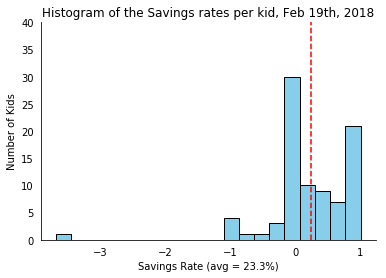

In [46]:
# Savings per kid
fig1, ax1 = plt.subplots()
fig1 = plt.hist(avg_save, color='skyblue', ec='black', bins=20)
ax1.tick_params(bottom="off", top="off", left="off", right="off")
ax1.set_title('Histogram of the Savings rates per kid, Feb 19th, 2018')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylabel('Number of Kids')
ax1.set_xlabel('Savings Rate (avg = 23.3%)')
plt.axvline(0.233, color='red', linestyle='dashed')
ax1.set_ylim(0,40)
plt.show()


This average savings rate, though, does not take in to account kids starting balances. Hence the negative savings rates - how could a kid have spent more than they earned if they didn't already have some money in the bank? So, let's try to take a look at savings rates as a function of account closing balances.

##Monthly Closing Balances as Savings

To try and look at this I utilized the "Closing Balance" variable. Each kid has a closing account balance each month from August 2017 through January 2018 (6 months). So I decided to try and look at this by looking at closing account balances relative to their starting point in August. In order to do this, in the following code I grouped the data by BPID, and subtracted each kids closing balance in their first month from every other balance, giving us a difference score measuring the overall growth, or shrinkage, of their bank account over the 6 months.

So, for reference, if I was a kid and at the end of each of the 6 months had closing balances of $10, $12, $14, $16, $18, and $20, our difference scores catching this growth would be $0, $2, $4, $6, $8, $10. First things first, lets trim up the data set to just have the variables we want, and only the rows we want.

In [39]:
# Trim into a smaller dataset with just the vars I care about
bal_cols = ['Primary BP', 'Product', 'Rpt Month', 'Closing Balance']
monthly_data = data[bal_cols]

# Keep only the generation accounts
monthly_data = monthly_data.loc[monthly_data['Product'] == 'DP_GENRATN']

# Trim the data to have only unique values of the month
monthly_data = monthly_data.drop_duplicates(['Rpt Month', 'Closing Balance'])
print(monthly_data)


      Primary BP     Product Rpt Month Closing Balance
0         613570  DP_GENRATN    201708          761.04
1         613570  DP_GENRATN    201709           761.1
2         613570  DP_GENRATN    201710          761.16
3         613570  DP_GENRATN    201711          761.22
4         613570  DP_GENRATN    201712          761.28
5         613570  DP_GENRATN    201801          761.34
6         623262  DP_GENRATN    201708           76.16
30        623262  DP_GENRATN    201709        1,357.84
52        623262  DP_GENRATN    201710           16.03
79        623262  DP_GENRATN    201711        1,079.42
85        623262  DP_GENRATN    201712        1,024.56
136       623262  DP_GENRATN    201801          442.91
159       654016  DP_GENRATN    201708        1,070.46
217       654016  DP_GENRATN    201709        2,034.56
263       654016  DP_GENRATN    201710          247.14
317       654016  DP_GENRATN    201711        1,192.51
386       654016  DP_GENRATN    201712        2,271.85
441       

Next, lets write a for loop that iterates over this dataset and does exactly what I described above - subtracts each kids first closing balance from the rest of their closing balances, and saves it as a new variable in the dataset.

In [40]:
# Housekeeping for the for loop - creating a difference variable in closing balance.
# How much does their balance go up or down on a month to month basis?
bpid = []
diffs = []
monthly_data['Closing Balance'] = monthly_data['Closing Balance'].str.replace(",", "")
monthly_data['Closing Balance'] = pd.to_numeric(monthly_data['Closing Balance'])

# Create a new variable in monthly_data that simply shows the increase in closing balance for each month,
# setting the first month to 0
for index, row in monthly_data.iterrows():
    bp = row[0]
    if bp not in bpid:
        bpid.append(bp)
        first = row[3]
    bal = row[3]
    diff = round(bal-first, 2)
    diffs.append(diff)
    row['balance increase'] = diff

Lets check quickly - we had 418 rows in the above dataset - do we have 418 of these new difference scores?

In [41]:
print(len(diffs))

418


Great, so now lets merge them into our dataset and take a quick eyeball to make sure its right.

In [42]:
# Convert my list of differences in closing balance to a series object, and merge with the monthly_data
se = pd.Series(diffs)
monthly_data['balance increase'] = se.values

# Check it out. Looks good to go.
print(monthly_data.head(15))

     Primary BP     Product Rpt Month  Closing Balance  balance increase
0        613570  DP_GENRATN    201708           761.04              0.00
1        613570  DP_GENRATN    201709           761.10              0.06
2        613570  DP_GENRATN    201710           761.16              0.12
3        613570  DP_GENRATN    201711           761.22              0.18
4        613570  DP_GENRATN    201712           761.28              0.24
5        613570  DP_GENRATN    201801           761.34              0.30
6        623262  DP_GENRATN    201708            76.16              0.00
30       623262  DP_GENRATN    201709          1357.84           1281.68
52       623262  DP_GENRATN    201710            16.03            -60.13
79       623262  DP_GENRATN    201711          1079.42           1003.26
85       623262  DP_GENRATN    201712          1024.56            948.40
136      623262  DP_GENRATN    201801           442.91            366.75
159      654016  DP_GENRATN    201708          1070

Looks right to me. Let's try to plot out these balance changes across the six months.

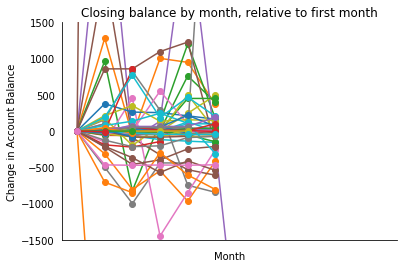

In [76]:
# Plotting the balance increase with months as the ticks, and lines for each kid. Centered on zero
fig2, ax2 = plt.subplots()


for key, grp in monthly_data.groupby(['Primary BP']):
    ax2 = grp.plot(ax=ax2, marker = 'o', x='Rpt Month', y='balance increase')
ax2.legend_.remove()
ax2.tick_params(bottom="off", top="off", left="off", right="off")
ax2.set_title('Closing balance by month, relative to first month')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_ylabel('Change in Account Balance')
ax2.set_xlabel('Month')
ax2.set_ylim(-1500,1500)
plt.show()


Sorry for the squished nature of this particular graph. I fought with it for a while but couldn't figure out why there seems to be space for two graphs here. I will still interpret it though because the conclusions are unchanged. One more thing to note is that I've intentionally trimmed the y-axis. There are two kids where you cannot see the end: (1) the kid who has the massive amounts of money money through their account (in excess of $30,000) and (2) one kid who's closing balances drops well into the negative thousands.

Not worrying about those two outliers, though, what you see in this graph with respect to closing balances is exactly what I would expect given what we've seen so far - most kids seem to just be hovering aroung zero. Just eyeballing these lines, a good chunk of the kids actually end the 6 months with less money than they started with, or right around zero.

Looking at this, it seems like kids just earn and spend a lot, never building up their account balances to more than about $500. So spending seems to be existing at an unsustainable rate.

## Savings rate by age category

One last analysis, as I mentioned above, is getting the actual average savings rate for each kid, lumping them together by their age groups, and then getting the true averages. Let's first just get a table of each kid and their age group

In [77]:
# One more pivot table, with each kid and their age group
amounts_moved_kid = pd.pivot_table(data, values='Trxn Amount', index=['Primary BP', 'Age Grp'], columns=['Debit Credit Flg'],
                                   aggfunc=sum)
# Add in a savings rate column
amounts_moved_kid['savings'] = ((amounts_moved_kid['CR'] - amounts_moved_kid['DB']) / amounts_moved_kid['CR'])*100

print(amounts_moved_kid)


Debit Credit Flg                  CR        DB     savings
Primary BP Age Grp                                        
613570     2. 10 to 12 yrs      0.36       NaN         NaN
623262     6. 17 yrs         5590.99   5249.68    6.104643
654016     6. 17 yrs        13080.29  13253.80   -1.326500
800222     1. 1 to 9 yrs    23309.62  25773.65  -10.570872
904341     6. 17 yrs         3725.76   3734.65   -0.238609
932022     6. 17 yrs        10861.84  11305.51   -4.084667
938237     4. 15 yrs         4288.24   3800.17   11.381592
938266     3. 13 to 14 yrs    250.00    192.14   23.144000
1299498    6. 17 yrs          560.61   1000.00  -78.377125
1300140    3. 13 to 14 yrs      1.36       NaN         NaN
1300744    1. 1 to 9 yrs      205.07    280.40  -36.733798
1305122    2. 10 to 12 yrs     25.12       NaN         NaN
1305732    5. 16 yrs        13333.03  16086.07  -20.648270
1320153    6. 17 yrs         7231.56   6886.73    4.768404
1329919    3. 13 to 14 yrs    582.15       NaN         N

Now, just going off this and aggregating by age group - what is the average savings rate for each set of kids?

In [79]:
# Now need to make a pivot table off the pivot table, getting average savings rate by age group
better_aged = pd.pivot_table(amounts_moved_kid, values='savings', index=['Age Grp'])
print(better_aged)


Debit Credit Flg       savings
Age Grp                       
1. 1 to 9 yrs        15.122325
2. 10 to 12 yrs      -5.653282
3. 13 to 14 yrs  -20628.418719
4. 15 yrs            -5.042239
5. 16 yrs           -21.773553
6. 17 yrs             0.294275


Again, thera are clearly issues with outliers - 13-14 year old kids having a -20,628% savings rate. Lets just remove anyone with less than a -500% savings rate.

We see below one kid has an extremely negative savings rate.

In [82]:
# There are clearly some outliers here as the average savings rate for 13-14 year olds is -20,628%
# Check to see any values over 500
amounts_moved_kid['savings'] = pd.to_numeric(amounts_moved_kid['savings'])
for index, row in amounts_moved_kid.iterrows():
    if row[2] <= -500:
        print(row[2])

# This shows us there is one person who apparently had a savings rate of -227172.7272.72% - remove
amounts_moved_kid = amounts_moved_kid[amounts_moved_kid.savings > -500]

Okay - so just going to re-do this table without that kid, and plot it out.

Debit Credit Flg    savings
Age Grp                    
1. 1 to 9 yrs     15.122325
2. 10 to 12 yrs   -5.653282
3. 13 to 14 yrs   26.012137
4. 15 yrs         -5.042239
5. 16 yrs        -21.773553
6. 17 yrs          0.294275


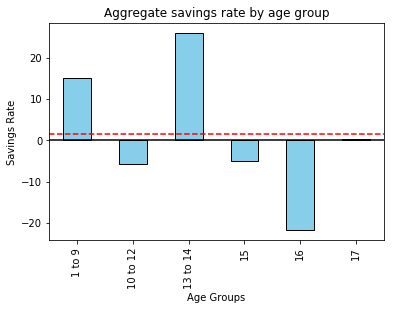

In [83]:
# Recalc the pivot table
better_aged2 = pd.pivot_table(amounts_moved_kid, values='savings', index=['Age Grp'])
print(better_aged2)

better_aged2['savings'].plot.bar(color='skyblue', ec='black')
plt.ylabel('Savings Rate')
plt.title('Aggregate savings rate by age group')
plt.xlabel('Age Groups')
plt.axhline(better_aged2['savings'].mean(), linestyle='dashed', color='red')
plt.axhline(0, color='black')
plt.gca().set_xticklabels(['1 to 9', '10 to 12', '13 to 14', '15', '16', '17'])
plt.show()

There we have it - the average savings rate, by age group, with the overall average (1.4%) plotted with the red dashed line. Notice how you can't see the bar for the 17 year olds. That's because the value is only 0.29%. The overall average savings rate is 1.49%, when you take into account that 4 of the 6 groups are either (a) spending more than they earn or (b) saving nothing.

# Conclusions

While the sample I was working with was relative small, and there were clear oddities present within them, I analyzed the earning and spending data in a handful of different ways. First, I looked at aggregate savings, then aggregate savings by age group. These analyses showed promising rates of saving among the kids (seemingly hovering around 10-20%). However, as I pointed out, aggregate calculations like this are not the greatest. So I followed these up with a series of analyses in which I calculated each individual kids saving rate and took the average, where we saw a mean savings of about 23% - again, a somewhat rosy picture.

The last two analyses I ran paint less rosy, but more accurate, pictures of typical spending and saving behavior in this sample of 100 kids. First, looking at closing account balances by month we see that most kids, across a 6 month time span, the kids didn't generally accumulate money. Many kids ended up with account balances lower than where they started 6 months previously, or very close to zero. Second,I calculated the average savings rate by age group and saw that 4 out of 6 age groups spent more than they earned in a six month period. 

This shows that kids are, particularly as they get older, behaving in such a way that they are not accumulating money and generally spending it as fast as they are earning it, or faster.

Obviously, these analyses are limited. They are just my interpretation of a handful of visualizations - I did not run any actual inferential tests. While it appears that depending on the way the data are sliced the average savings rate can fluctuate wildly, the latter analyses are the most appropriate and thus likely the closest to reality.